## Week 10 notebook

For this week, include the following ideas: k-means; specifically elbow method, Silhouette score, feature scaling, and distance metrics. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.cluster import KMeans

# data preprocesing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Classification metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report, silhouette_score

random_state = 0

In [2]:
def encoding(df_or_series, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: (encoded DataFrame, mappings dict or list of new columns)
        If input is Series: (encoded Series, mapping dict)
    """
    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded, mapping
    
    elif isinstance(df_or_series, pd.DataFrame):
        if one_hot:
            if cat_cols is None:
                cat_cols = df_or_series.select_dtypes(include=['object', 'category']).columns.tolist()
            df_encoded = pd.get_dummies(df_or_series, columns=cat_cols, drop_first=True)
            new_cols = [col for col in df_encoded.columns if col not in df_or_series.columns or col in cat_cols]
            return df_encoded, new_cols
        else:
            df_encoded = df_or_series.copy()
            mappings = {}
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            for col in cat_cols:
                uniques = df_encoded[col].dropna().unique().tolist()
                mapping = {cat: code for code, cat in enumerate(uniques)}
                mappings[col] = mapping
                df_encoded[col] = df_encoded[col].map(mapping).astype("int64")
            return df_encoded, mappings
    
    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [3]:
def load_and_split_data(file_path: str, target_col: str = None, one_hot: bool = False, test_size: float = 0.2, random_state: int = 0, scaling: str = 'norm'):
    """
    Loads data, encodes categorical features, splits into train/test, and scales features.

    Args:
        file_path: Path to CSV file.
        target_col: Name of target column. If None, uses last column.
        test_size: Fraction for test split.
        random_state: Random seed.
        scaling: 'norm' (MinMax), 'reg' (Standard), or None.

    Returns:
        X_train, X_test, y_train, y_test, df, mappings
    """
    df = pd.read_csv(file_path)
    
    # Select target
    if target_col is None:
        target_col = df.columns[-1]
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode Categorical Features
    if one_hot is True:
        X_encoded, new_cols = encoding(X, one_hot=True)
        y_encoded, mappings = encoding(y)
    else:
        X_encoded, mappings = encoding(X)
        y_encoded, mappings = encoding(y)
        

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=test_size, random_state=random_state
    )

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Scaling
    if scaling == 'reg':
        scaler = StandardScaler()
    elif scaling == 'norm':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train, X_test, y_train, y_test, df, mappings


In [4]:
# Load the ins claims dataset with variations of encoding and scaling
X_train_ins_oh, X_test_ins_oh, y_train_ins_oh, y_test_ins_oh, df_ins_oh, ins_oh_mappings = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', 
    target_col='fraud_reported', one_hot=True, scaling='reg')

X_train_car_oh, X_test_car_oh, y_train_car_oh, y_test_car_oh, df_car_oh, car_oh_mappings = load_and_split_data(
    r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\carclaims_cleaned.csv',
    target_col='FraudFound', one_hot=True, scaling='reg')

In [5]:
def gridsearchcv(model, X_train, y_train, param_dict=None, random_state=random_state, scoring='accuracy', cv=None):
    """
    Generic grid search function for any sklearn model and parameter grid.

    Args:
        model: The sklearn model class (not an instance), e.g., SVC, RandomForestClassifier, etc.
        X_train: Training features.
        y_train: Training target.
        param_dict: Dictionary of parameter grid for the model.
        random_state: Random state for reproducibility.
        scoring: Scoring metric for GridSearchCV.
        cv: Cross-validation strategy (optional).

    Returns:
        grid_best_params: Best parameter dictionary.
        grid_cv_score: Best cross-validated score.
    """
    # If the model supports random_state, pass it; otherwise, ignore
    try:
        base_model = model(random_state=random_state)
    except TypeError:
        base_model = model()

    # Use provided cv or default to RepeatedStratifiedKFold for classification
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)

    search = GridSearchCV(
        estimator=base_model,
        param_grid=param_dict,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
        error_score='raise'
    )

    search.fit(X_train, y_train)

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Print top 5 results (show all param columns dynamically)
    param_cols = [col for col in results.columns if col.startswith('param_')]
    display_cols = param_cols + [
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]
    results = results[display_cols].sort_values(by='rank_test_score')
    renamed_results = results.rename(
        columns={col: col.replace('param_', '') for col in param_cols} |
                {'mean_test_score': 'mean_cv_score', 'std_test_score': 'std_cv_score'}
    ).drop(columns=['rank_test_score'])

    print("\nSearch Results (Top 5):\n")
    print(renamed_results.head(5).to_string(index=False))

    # Best parameters and test performance
    grid_best_params = search.best_params_
    print(f"\nBest Parameters: {grid_best_params}")
    grid_cv_score = search.best_score_
    print(f"Best CV Score: {grid_cv_score:.4f}")

    return grid_best_params, grid_cv_score

In [6]:
def elbow_method(data_used, X_data, k_range=range(2, 11), **model_params):
    """
    Perform elbow method analysis for optimal number of clusters.
    
    Args:
        data_used: String indicating the dataset used.
        X_data: Feature data for clustering.
        k_range: Range of k values to test.
        model_params: Additional parameters for KMeans.
    
    Returns:
        Dictionary with inertias and silhouette scores for each k.
    """
    inertias = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, **model_params)
        cluster_labels = kmeans.fit_predict(X_data)
        
        inertias.append(kmeans.inertia_)
        sil_score = silhouette_score(X_data, cluster_labels)
        silhouette_scores.append(sil_score)
    
    # Plot elbow method
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Inertia plot
    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title(f'Elbow Method for {data_used}')
    ax1.grid(True)
    
    # Silhouette score plot
    ax2.plot(k_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title(f'Silhouette Score for {data_used}')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal k based on silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
    print(f"Best silhouette score: {max(silhouette_scores):.4f}")
    
    return {
        'k_range': list(k_range),
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'optimal_k': optimal_k,
        'best_silhouette': max(silhouette_scores)
    }

In [9]:
def clustering_model(data_used, X_data, y_data, n_clusters, **model_params):
    """
    Function to fit and evaluate K-Means clustering model with silhouette score and confusion matrix.

    Args:
        data_used: String indicating the dataset used (for logging purposes).
        X_data: Feature data for clustering.
        n_clusters: Number of clusters.
        y_data: True labels for confusion matrix (optional).
        model_params: Additional parameters for KMeans.

    Returns:
        model: The fitted KMeans model.
        cluster_labels: The cluster assignments.
        results: Dictionary of results including silhouette score.
    """
    # Create and fit the KMeans model
    model = KMeans(n_clusters=n_clusters, random_state=random_state, **model_params)
    cluster_labels = model.fit_predict(X_data)
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_data, cluster_labels)
    
    # Calculate inertia (within-cluster sum of squares)
    inertia = model.inertia_
    
    print(f"K-Means Clustering Results for {data_used}:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Inertia: {inertia:.2f}")
    print(f"Cluster centers shape: {model.cluster_centers_.shape}")
    print("\n")
    
    # Plot confusion matrix if true labels are provided
    cm = confusion_matrix(y_data, cluster_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: True Labels vs Clusters\n{data_used}')
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Labels")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy if true labels are provided
    # Note: This is a rough approximation since cluster labels may not align with true labels
    accuracy = accuracy_score(y_data, cluster_labels)
    print(f"Cluster-to-Label Accuracy (approximate): {accuracy:.4f}")
    print("Note: This accuracy assumes cluster labels align with true labels, which may not be the case.")
    
    
    # Save results for later analysis
    results = {
        'data_used': data_used,
        'model_name': 'KMeans',
        'n_clusters': n_clusters,
        'model_params': model.get_params(),
        'silhouette_score': sil_score,
        'inertia': inertia,
        'cluster_labels': cluster_labels,
        'cluster_centers': model.cluster_centers_,
        'confusion_matrix': cm,
        'accuracy': accuracy if y_data is not None else None
    }
    
    return model, cluster_labels, results

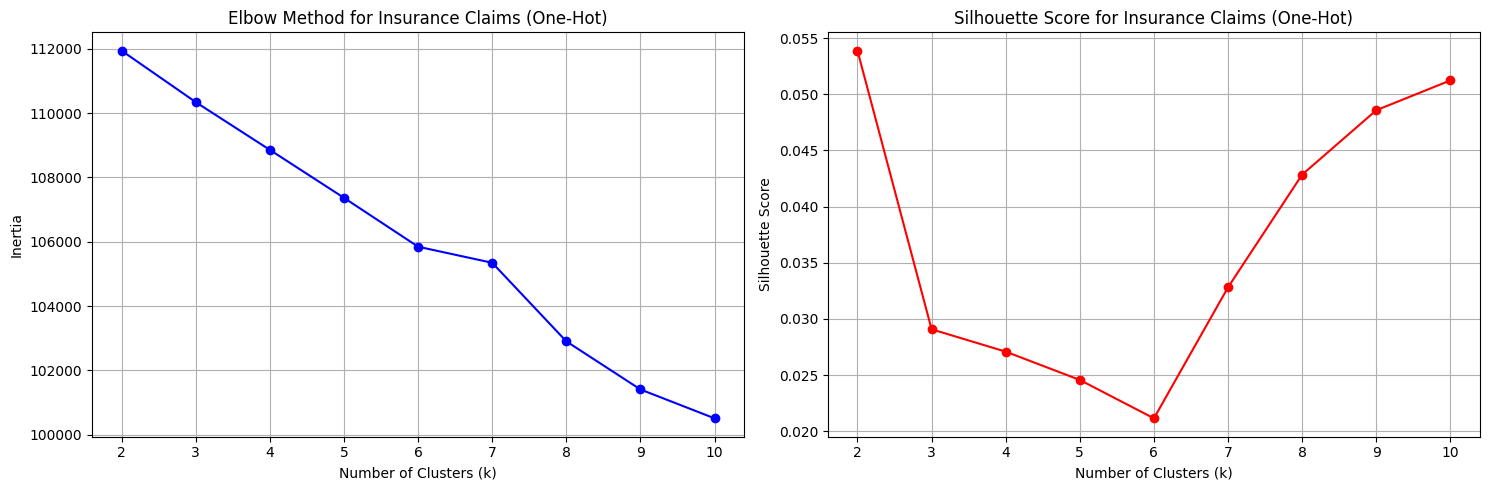

Optimal number of clusters based on silhouette score: 2
Best silhouette score: 0.0539
K-Means Clustering Results for Insurance Claims (One-Hot):
Number of clusters: 2
Silhouette Score: 0.0539
Inertia: 111938.21
Cluster centers shape: (2, 145)




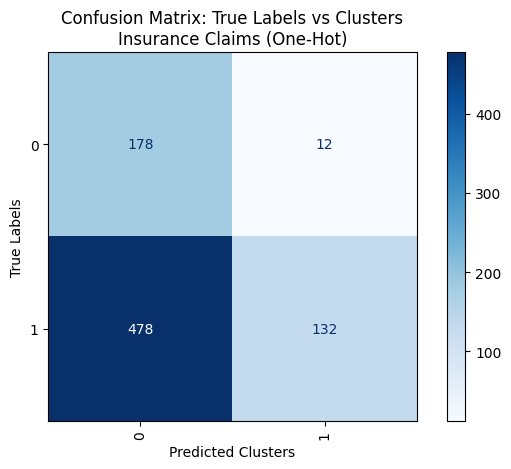

Cluster-to-Label Accuracy (approximate): 0.3875
Note: This accuracy assumes cluster labels align with true labels, which may not be the case.


In [10]:
# Perform elbow method analysis
elbow_results_ins = elbow_method("Insurance Claims (One-Hot)", X_train_ins_oh)

# Run clustering with optimal number of clusters
optimal_k_ins = elbow_results_ins['optimal_k']
model_ins, labels_ins, results_ins = clustering_model("Insurance Claims (One-Hot)", X_train_ins_oh, y_train_ins_oh, optimal_k_ins)

In [11]:
# Run Gridsearch on the car claims dataset with one-hot encoding
ins_oh_param_grid = {
    'n_clusters': range(2, 11),
    'init': ['k-means++', 'random'],
    'algorithm': ['lloyd', 'elkan']
}

grid_best_params_ins_oh, grid_cv_score_ins_oh = gridsearchcv(
    KMeans, X_train_ins_oh, y_train_ins_oh, param_dict=ins_oh_param_grid, random_state=random_state, scoring='accuracy')


Search Results (Top 5):

algorithm      init  n_clusters  mean_cv_score  std_cv_score  mean_train_score  std_train_score
    lloyd k-means++           2         0.5075      0.135750          0.501500         0.135523
    elkan k-means++           2         0.5075      0.135750          0.501500         0.135523
    elkan    random           2         0.4925      0.113963          0.485000         0.111604
    lloyd    random           2         0.4925      0.113963          0.485000         0.111604
    lloyd k-means++           3         0.3865      0.165913          0.384562         0.165272

Best Parameters: {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2}
Best CV Score: 0.5075


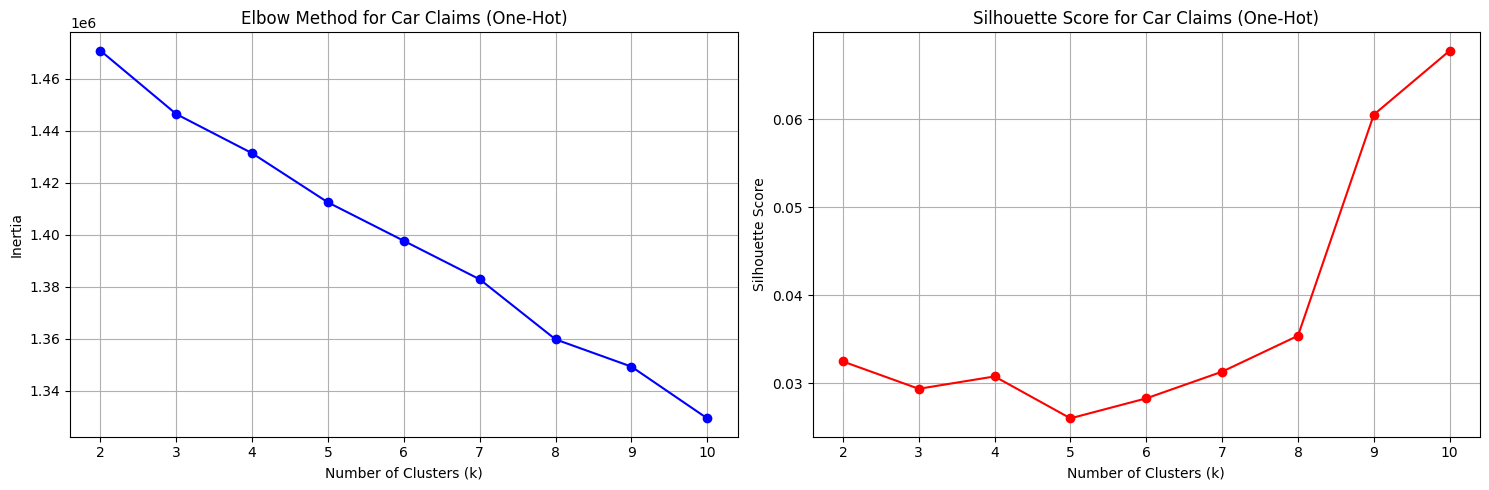

Optimal number of clusters based on silhouette score: 10
Best silhouette score: 0.0678
K-Means Clustering Results for Insurance Claims (One-Hot):
Number of clusters: 10
Silhouette Score: 0.0678
Inertia: 1329421.24
Cluster centers shape: (10, 123)




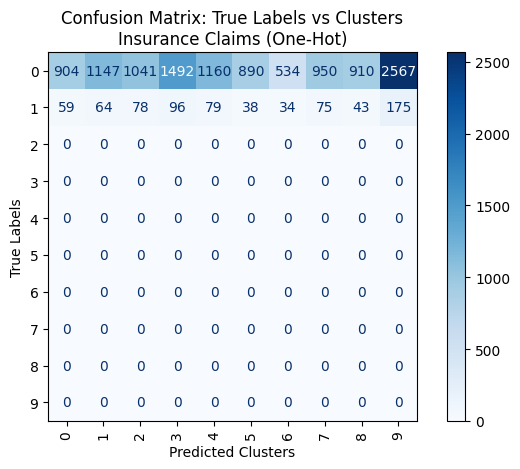

Cluster-to-Label Accuracy (approximate): 0.0785
Note: This accuracy assumes cluster labels align with true labels, which may not be the case.


In [12]:
# Perform elbow method analysis
elbow_results_car = elbow_method("Car Claims (One-Hot)", X_train_car_oh)

# Run clustering with optimal number of clusters
optimal_k_car = elbow_results_car['optimal_k']
model_car, labels_car, results_car = clustering_model("Insurance Claims (One-Hot)", X_train_car_oh, y_train_car_oh, optimal_k_car)

In [13]:
# Run Gridsearch on the car claims dataset with one-hot encoding
car_oh_param_grid = {
    'n_clusters': range(2, 11),
    'init': ['k-means++', 'random'],
    'algorithm': ['lloyd', 'elkan']
}

grid_best_params_car_oh, grid_cv_score_car_oh = gridsearchcv(
    KMeans, X_train_car_oh, y_train_car_oh, param_dict=car_oh_param_grid, random_state=random_state, scoring='accuracy')


Search Results (Top 5):

algorithm      init  n_clusters  mean_cv_score  std_cv_score  mean_train_score  std_train_score
    lloyd k-means++           2       0.590619      0.276476          0.593299         0.275201
    elkan k-means++           2       0.590619      0.276476          0.593299         0.275201
    elkan    random           2       0.479053      0.117256          0.478992         0.116954
    lloyd    random           2       0.479053      0.117256          0.478992         0.116954
    lloyd k-means++           3       0.349371      0.182613          0.350060         0.180474

Best Parameters: {'algorithm': 'lloyd', 'init': 'k-means++', 'n_clusters': 2}
Best CV Score: 0.5906
